# Machine Learning for Multibody System Dynamics

## **Session 2-1:** Surrogate Modeling – Duffing Oscillator with External Forcing

Grzegorz Orzechowski & Peter Manzl

> DNN trained on Duffing‐oscillator dynamics with randomized forces or harmonics.

## Duffing Oscillator 

In this file, a deep neural network is trained on the dynamics of a [Duffing oscillator](https://en.wikipedia.org/wiki/Duffing_equation). The equations of motion (EOM) are:

$$m \,\ddot{x} + d \,\dot{x} + k \,x + \alpha \,k \,x^3 = F(t).$$

In the used dataset, parameters are fixed as:
-  $m = 1$,
-  $k = 1600$,
-  $d = 8$,
-  $\alpha = 1$.

Randomized forces $F_i$ are applied in the range $\bigl[-2000,\,2000\bigr]$. For learning, inputs are normalized as $\hat{f}_i = \tfrac{1}{2000}F_i$.

**Input vector**:

$\bigl[x_0,\;\dot{x}_0,\;\hat{f}_0,\;\dots,\;\hat{f}_{n-1}\bigr]^T.$

**Output vector**:
$\bigl[x_1,\;x_2,\;\dots,\;x_n\bigr]^T, \quad x_i = x\bigl(t = i\,h\bigr),\quad h = \tfrac{0.5}{64}.$

- **Dataset 1**: Randomized forces for each sample.
- **Dataset 2**: Randomized harmonics with $\omega \in [0,\,4\pi]$ (uniform), amplitude also in $[-2000,\,2000]$.

Below, we generate both datasets, train a DNN surrogate, and compare predictions to true trajectories.

In [1]:
# 1) Imports & Device Setup
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import time
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Problem Setup

- Time step: $h = \tfrac{0.5}{64}$.
- Number of steps per trajectory: $n = 64$.
- Total integration time: $T = n \times h = 0.5\,$s.
- Time vector: $t_i = i\,h$ for $i=0,\dots,n$.

Define constants and the Duffing ODE (second-order rewritten as first-order).

In [2]:
# 2) Constants & time grid
m, k, damp, alpha = 1.0, 1600.0, 8.0, 1.0
n_steps = 64
h       = 0.5 / n_steps
T       = h * n_steps
t_steps = np.linspace(0, T, n_steps+1)

In [3]:
# 3) Duffing RHS (first-order form)
def duffing_rhs(t, u, forces):
    # u = [x, v]
    idx = min(int(t / h), len(forces)-1)
    F_t = forces[idx]
    x, v = u
    dx = v
    dv = F_t - damp * v - k * x - alpha * k * x**3
    return [dx, dv]

## Generate Dataset 1: Randomized Forces

For each sample:
1. Random initial state $\bigl(x_0,\dot{x}_0\bigr)\in[-1,\,1]$.
2. Random force sequence $F_i \sim \mathcal{U}(-2000,\,2000)$ for $i=0,\dots,\,n-1$.
3. Normalize $\hat{f}_i = F_i / 2000$.
4. Integrate the ODE for $t\in[0,\,T]$ with forcing $F(t)$ piecewise constant on $[i\,h,\,(i+1)\,h)$.
5. Record positions $x_1,\dots,x_n$ at $t=h,\dots,T$.

In [4]:
# 4) Dataset 1
rng = np.random.default_rng(123)
N1 = 2000

inputs1  = np.zeros((N1, 2 + n_steps), dtype=np.float32)
targets1 = np.zeros((N1, n_steps),    dtype=np.float32)

for i in range(N1):
    x0 = rng.random()*2 - 1
    v0 = rng.random()*2 - 1
    F_seq = rng.random(n_steps)*4000 - 2000
    fhat  = F_seq / 2000.0

    inputs1[i, 0]   = x0
    inputs1[i, 1]   = v0
    inputs1[i, 2:]  = fhat

    sol = solve_ivp(lambda t,y: duffing_rhs(t,y,F_seq),
                    (0, T), [x0, v0],
                    t_eval=t_steps, method='RK45')
    # record x at t_steps[1:]
    targets1[i] = sol.y[0, 1:]

print(f"Dataset1 ⇒ inputs {inputs1.shape}, targets {targets1.shape}")

Dataset1 ⇒ inputs (2000, 66), targets (2000, 64)


## Generate Dataset 2: Randomized Harmonics

For each sample:
1. Random initial state $(x_0,\dot{x}_0)$.
2. Random amplitude $A \sim \mathcal{U}(-2000,\,2000)$, random $\omega \sim \mathcal{U}(0,\,4\pi)$.
3. Define force sequence $F_i = A \sin(\omega \, t_i)$, then normalize: $\hat{f}_i = F_i/2000$.
4. Integrate Duffing ODE with this forcing and record $x_1,\dots,x_n$.

In [5]:
# 5) Dataset 2
rng = np.random.default_rng(456)
N2 = 2000

inputs2  = np.zeros((N2, 2 + n_steps), dtype=np.float32)
targets2 = np.zeros((N2, n_steps),    dtype=np.float32)

for i in range(N2):
    x0 = rng.random()*2 - 1
    v0 = rng.random()*2 - 1
    A  = rng.random()*4000 - 2000
    ω  = rng.random()*(4*np.pi)

    F_seq = A * np.sin(ω * t_steps[:-1])
    fhat  = F_seq / 2000.0

    inputs2[i, 0]  = x0
    inputs2[i, 1]  = v0
    inputs2[i, 2:] = fhat

    sol = solve_ivp(lambda t,y: duffing_rhs(t,y,F_seq),
                    (0, T), [x0, v0],
                    t_eval=t_steps, method='RK45')
    targets2[i] = sol.y[0,1:]

print(f"Dataset2 ⇒ inputs {inputs2.shape}, targets {targets2.shape}")

Dataset2 ⇒ inputs (2000, 66), targets (2000, 64)


## Combine & Split

Stack both datasets and split 80 / 20 for train / test.

In [6]:
# 6) Combine & train/test split
X_all = np.vstack([inputs1, inputs2])
Y_all = np.vstack([targets1, targets2])
N_all = X_all.shape[0]

perm = np.arange(N_all)
rng.shuffle(perm)
split = int(0.8 * N_all)
tr_idx, te_idx = perm[:split], perm[split:]

X_train = torch.from_numpy(X_all[tr_idx]).float().to(device)
Y_train = torch.from_numpy(Y_all[tr_idx]).float().to(device)
X_test  = torch.from_numpy(X_all[te_idx]).float().to(device)
Y_test  = torch.from_numpy(Y_all[te_idx]).float().to(device)

print(f"Train: {len(tr_idx)} samples, Test: {len(te_idx)} samples")

Train: 3200 samples, Test: 800 samples


## Define the Surrogate MLP

Architecture:
- Input dim = \(2 + 64\)
- Hidden layers:  
  128 → 64 → 32  
  (Sigmoid activations + Dropout 0.05)
- Output dim = 64

In [7]:
# 7) Fixed MLP surrogate
class SurrogateMLP(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.05):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(32, n_steps),
        )
    def forward(self, x):
        return self.net(x)

model = SurrogateMLP(2 + n_steps, dropout_rate=0.05).to(device)

## Regularization in Neural Networks

<img src="../figures/overfitting.png" alt="fig" width="350" align="right" style="padding: 30px;" />

In Deep Learning __overfitting__ occurs when the model reproduces the training dataset well, but fails on the validation/test dataset. 

**Why Regularize?**

- Prevent **overfitting**: too complex models memorize training data
- Improve **generalization**: better performance on unseen data
- Control **model complexity** and **training stability**

**Common Techniques**

1. **L2 Weight Decay**  
   Penalize large weights by adding $\lambda\|w\|^2$ to the loss
2. **Dropout**  
   Randomly disable neurons during training to prevent co-adaptation
3. **Early Stopping**  
   Stop training when validation loss stops improving
4. **Data Augmentation**  
   Expand dataset by applying transformations (e.g., noise, shifts)
5. **Batch Normalization**  
   Normalize activations to reduce internal covariate shift
6. **L1 Regularization**  
   Encourage weight sparsity via $\lambda\|w\|_1$

**Guidelines for Hyperparameters**

- **L2 λ**: typically in $[10^{-6},10^{-2}]$
- **Dropout rate**: often between 0.1 and 0.5
- Combine multiple methods for best generalization

**Note on AdamW** – valid for othe _W_ variants of optimizers

- `AdamW` = `Adam` + decoupled weight decay
- It’s a regularizer built into the optimizer.
- Equivalent to L₂ weight‐decay, but implemented so it doesn’t interfere with Adam’s adaptive moment estimates.

## Reusable Training Function with Early Stopping

We define `train_loop` that:
- Accepts a `model`, an optimiser algorithm, a training DataLoader and a validation DataLoader.
- Trains for up to `n_epochs` epochs, recording training and validation loss each epoch.
- Stops early if validation loss does not improve for `patience` consecutive epochs.


In [8]:
# 8) Training helper
def train_loop(model, optimizer, train_loader, val_loader, loss_fn,
               n_epochs=2000, patience=50):
    best_val = float('inf')
    no_imp   = 0
    best_wts = model.state_dict()
    train_hist, val_hist = [], []
    
    for epoch in range(1, n_epochs+1):
        # — train —
        model.train()
        run_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            optimizer.step()
            run_loss += loss.item()
        train_hist.append(run_loss / len(train_loader))
        
        # — validate —
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                val_loss += loss_fn(model(xb), yb).item()
        val_loss /= len(val_loader)
        val_hist.append(val_loss)
        
        # — early stop check —
        if val_loss < best_val:
            best_val = val_loss
            best_wts = model.state_dict()
            no_imp = 0
        else:
            no_imp += 1
            if no_imp >= patience:
                print(f"Early stopping @ epoch {epoch}")
                break
    
    model.load_state_dict(best_wts)
    return train_hist, val_hist

## Actual training with Early Stopping

- **Optimizer:** AdamW (lr = 2e-3, weight_decay = 1e-2)  
- **Loss:** MSE  
- **Epochs:** up to 2000  
- **Batch size:** 256  
- **Patience:** 50 epochs

In [9]:
# 9) Actual training
batch_size    = 256
lr            = 2e-3
weight_decay  = 1e-2
loss_fn     = nn.MSELoss()
optimizer     = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

train_loader = DataLoader(TensorDataset(X_train, Y_train),
                          batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_test,  Y_test),
                          batch_size=batch_size, shuffle=False)

torch.manual_seed(432)
t0 = time.time()
train_hist, val_hist = train_loop(
    model, optimizer, 
    train_loader, val_loader,
    loss_fn,
    n_epochs=2000, patience=50
)
print(f"Training finished in {time.time()-t0:.1f}s")
print(f"Final validation loss: {val_hist[-1]:.6f}")

Early stopping @ epoch 318
Training finished in 5.9s
Final validation loss: 0.029683


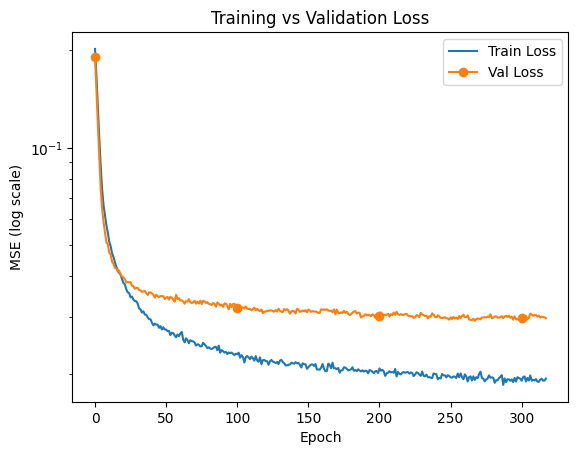

In [10]:
# 10) Plot Training & Validation Loss
plt.figure()
plt.semilogy(train_hist, label='Train Loss')
plt.semilogy(val_hist,   label='Val Loss', marker='o', markevery=100)
plt.xlabel('Epoch')
plt.ylabel('MSE (log scale)')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

## Example Prediction vs. True Trajectory

Pick a random test sample and compare.

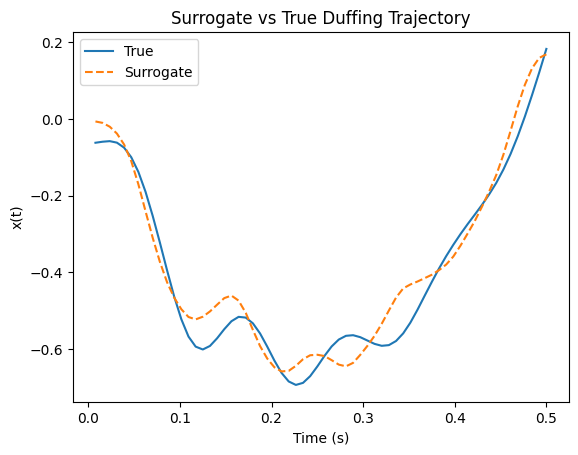

In [11]:
# 11) Compare one test case
idx = random.randrange(len(X_test))
x_in = X_test[idx:idx+1]
true = Y_test[idx].cpu().numpy()

with torch.no_grad():
    pred = model(x_in).cpu().numpy().ravel()

t_plot = t_steps[1:]  # times at x_1..x_64

plt.figure()
plt.plot(t_plot, true, label='True')
plt.plot(t_plot, pred, '--', label='Surrogate')
plt.xlabel('Time (s)')
plt.ylabel('x(t)')
plt.title('Surrogate vs True Duffing Trajectory')
plt.legend()
plt.show()

## Final Notes

- Two datasets were generated:
  1. Randomized force sequences in $[-2000,\,2000]$.
  2. Randomized harmonic forces $A\sin(\omega t)$ with $A\in[-2000,2000]$, $\omega\in[0,4\pi]$.
- Inputs include $(x_0, \dot{x}_0)$ and normalized forces $\hat{f}_i\in[-1,1]$.
- The DNN maps inputs $\in\mathbb{R}^{2+64}$ to outputs $\in\mathbb{R}^{64}$.
- Loss is MSE on the entire trajectory.
- We use several regularization strategies: early stopping, dropout layers, and L2 weight regularization.
- You can adjust `hidden_dim`, learning rate (`lr`), `nEpoch`, `batchSize`, or network depth/width for improved performance.
- For larger datasets, consider data normalization or more advanced architectures (e.g., convolutional, recurrent).